# A/B Marketing

## Dataset
https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing

As empresas de marketing desejam executar campanhas bem-sucedidas, mas o mercado é complexo e várias opções podem funcionar. Por isso, normalmente realizam testes A/B, que são um processo de experimentação randomizado no qual duas ou mais versões de uma variável (página da web, elemento da página, banner etc.) são mostradas para diferentes segmentos de pessoas ao mesmo tempo, a fim de determinar qual versão gera o maior impacto e impulsiona as métricas de negócios.  


### Informações sobre os dados  

- **test group**: Se for `"ad"`, a pessoa viu o anúncio; se for `"psa"`, ela viu apenas o anúncio de utilidade pública.  
- **converted**: Se a pessoa comprou o produto, então `True`; caso contrário, `False`.  
- **total ads**: Quantidade de anúncios vistos pela pessoa.  
- **most ads day**: Dia em que a pessoa viu a maior quantidade de anúncios.  
- **most ads hour**: Hora do dia em que a pessoa viu a maior quantidade de anúncios.  


## Importações

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm
from scipy.stats import chi2_contingency

## Extração

In [ ]:
df = pd.read_csv('data/marketing_AB.csv')
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [67]:
df = df.drop(columns=['Unnamed: 0', 'user id'])
df = df[['test group', 'total ads', 'most ads day', 'most ads hour', 'converted']]
df.head()

,test group,total ads,most ads day,most ads hour,converted
0,ad,130,Monday,20,False
1,ad,93,Tuesday,22,False
2,ad,21,Tuesday,18,False
3,ad,355,Tuesday,10,False
4,ad,276,Friday,14,False


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   test group     588101 non-null  object
 1   total ads      588101 non-null  int64 
 2   most ads day   588101 non-null  object
 3   most ads hour  588101 non-null  int64 
 4   converted      588101 non-null  bool  
dtypes: bool(1), int64(2), object(2)
memory usage: 18.5+ MB


## Análise


### Teste A/B: "Grupos de teste" e "Conversões"

Há alguma diferença na taxa de conversão entre os grupos AD e PSA?

**Hipótese Nula**: Não há diferença significativa entre as taxas de conversão dos grupos (P(ad) - P(psa) = 0)  
**Hipótese Alternativa**: Há diferença significativa entre as taxas de conversão (P(ad) - P(psa) ≠ 0)  
**Nível de Significância**: 0.05

In [69]:
ad_psa_conversion = df.groupby(['test group', 'converted'])['converted'].count()
ad_psa_conversion

test group  converted
ad          False        550154
            True          14423
psa         False         23104
            True            420
Name: converted, dtype: int64

In [70]:
converted_arr = ad_psa_conversion.iloc[1::2].values
not_converted_arr = ad_psa_conversion.iloc[0::2].values

ad_psa_conversion = pd.DataFrame({'converted': converted_arr,
                                  'not converted': not_converted_arr},
                                 index=['ad', 'psa'])

ad_psa_conversion['total'] = ad_psa_conversion['converted'] + ad_psa_conversion['not converted']

ad_psa_conversion

,converted,not converted,total
ad,14423,550154,564577
psa,420,23104,23524


In [71]:
print('Taxa de conversão')
ad_psa_conversion['converted'] / ad_psa_conversion['total']

Taxa de conversão


,0
ad,0.025547
psa,0.017854


In [72]:
counts = ad_psa_conversion['converted'].values
nobs = ad_psa_conversion['total'].values

z_stat, p_value = proportions_ztest(counts, nobs)

print(f"Estatística Z: {z_stat:.4f}")
print(f"P-valor: {p_value:.4f}")

Estatística Z: 7.3701
P-valor: 0.0000


In [73]:
p1, p2 = counts / nobs
diff = p1 - p2
se = np.sqrt(p1 * (1 - p1) / nobs[0] + p2 * (1 - p2) / nobs[1])

z_critical = norm.ppf(0.975)

lower_bound = diff - z_critical*se
upper_bound = diff + z_critical*se

print(f"Intervalo de confiança de 95% para a diferença na taxa de conversão: ({lower_bound*100:.2f}%, {upper_bound*100:.2f}%)")

Intervalo de confiança de 95% para a diferença na taxa de conversão: (0.60%, 0.94%)


In [74]:
print(f'Performance relativa (lower): {(lower_bound/p2)*100:.2f}%')
print(f'Performance relativa (upper): {(upper_bound/p2)*100:.2f}%')

Performance relativa (lower): 33.33%
Performance relativa (upper): 52.84%


### Conclusões do Teste A/B: "Grupos de teste" e "Conversões"

Taxa de conversão do grupo AD: 2.55%  
Taxa de conversão do grupo PSA: 1.79%  

Utilizando o **Teste Z**, obtivemos um **p-valor < 0.0001**, permitindo rejeitar a hipótese nula. O intervalo de confiança de 95% para a diferença entre as taxas de conversão foi de **(0.60%, 0.94%)**.

Em termos percentuais, o grupo AD apresentou um aumento na conversão entre **33.33%** e **52.84%** em relação ao grupo PSA, evidenciando uma vantagem significativa.

Os dados demonstram que a estratégia aplicada no grupo AD gerou uma taxa de conversão significativamente maior que a do grupo PSA. Esses resultados indicam que a abordagem adotada no grupo AD teve um impacto positivo e relevante, validando a eficácia da campanha.

### Análise: "Anúncios Totais" e "Conversão"

Qual o impacto da quantidade de anúncios vistos pelas pessoas na taxa de conversão?

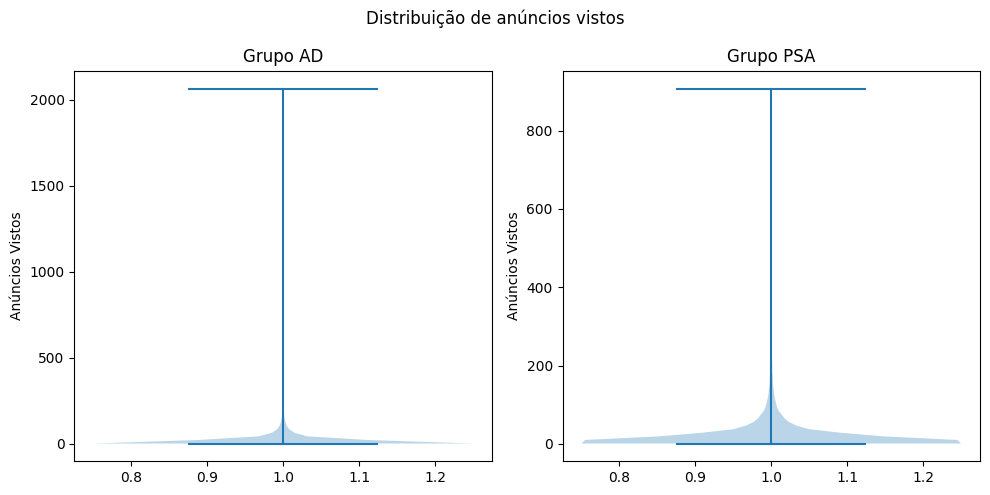

In [75]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Distribuição de anúncios vistos')

plt.subplot(1, 2, 1)
plt.violinplot(df.loc[df['test group'] == 'ad']['total ads'])
plt.title('Grupo AD')
plt.ylabel('Anúncios Vistos')

plt.subplot(1, 2, 2)
plt.violinplot(df.loc[df['test group'] == 'psa']['total ads'])
plt.title('Grupo PSA')
plt.ylabel('Anúncios Vistos')

plt.tight_layout()
plt.show()

In [76]:
totads_s140 = df[df['total ads'] <= 140].copy()

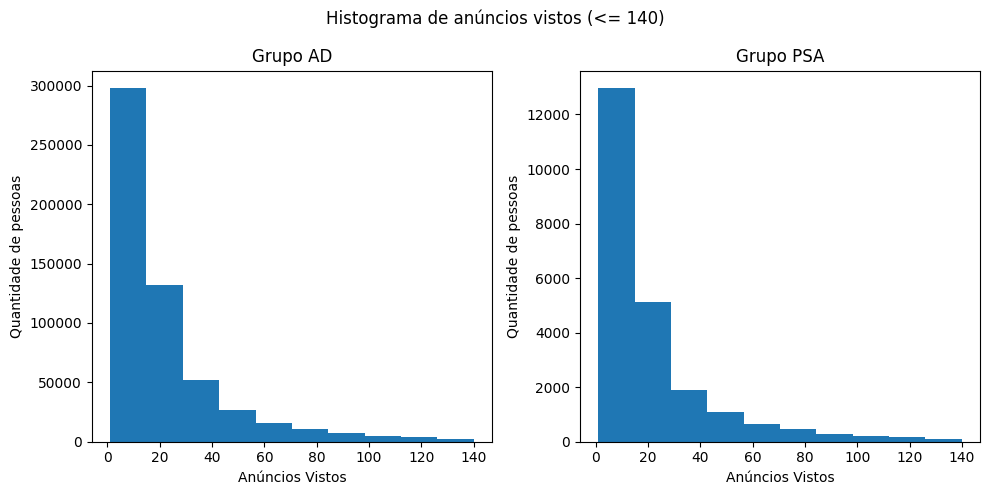

In [77]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Histograma de anúncios vistos (<= 140)')

plt.subplot(1, 2, 1)
plt.hist(totads_s140.loc[totads_s140['test group'] == 'ad']['total ads'])
plt.title('Grupo AD')
plt.xlabel('Anúncios Vistos')
plt.ylabel('Quantidade de pessoas')

plt.subplot(1, 2, 2)
plt.hist(totads_s140.loc[totads_s140['test group'] == 'psa']['total ads'])
plt.title('Grupo PSA')
plt.xlabel('Anúncios Vistos')
plt.ylabel('Quantidade de pessoas')

plt.tight_layout()
plt.show()

In [78]:
totads_s140['ads exposure'] = pd.cut(totads_s140['total ads'], bins=[0, 20, 40, 60, 80, 100, 120, 140], labels=['very-low', 'low', 'medium_low', 'medium', 'medium_high', 'high', 'very-high'])

In [79]:
totads_s140['ads exposure'].value_counts()

,count
ads exposure,
very-low,388259
low,107635
medium_low,38822
medium,19387
medium_high,10934
high,6562
very-high,4280


In [80]:
ad_exposure_conversion = totads_s140.groupby(['ads exposure', 'converted'])['converted'].count()
ad_exposure_conversion

<ipython-input-80-f69a8c65e800>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ad_exposure_conversion = totads_s140.groupby(['ads exposure', 'converted'])['converted'].count()


ads exposure  converted
very-low      False        386331
              True           1928
low           False        105150
              True           2485
medium_low    False         36261
              True           2561
medium        False         17106
              True           2281
medium_high   False          9245
              True           1689
high          False          5419
              True           1143
very-high     False          3494
              True            786
Name: converted, dtype: int64

In [81]:
converted_arr = ad_exposure_conversion.iloc[1::2].values
not_converted_arr = ad_exposure_conversion.iloc[0::2].values

ad_exposure_conversion = pd.DataFrame({'converted': converted_arr,
                                  'not converted': not_converted_arr},
                                 index=['very-low', 'low', 'medium_low', 'medium', 'medium_high', 'high', 'very-high'])

ad_exposure_conversion['total'] = ad_exposure_conversion['converted'] + ad_exposure_conversion['not converted']

ad_exposure_conversion

,converted,not converted,total
very-low,1928,386331,388259
low,2485,105150,107635
medium_low,2561,36261,38822
medium,2281,17106,19387
medium_high,1689,9245,10934
high,1143,5419,6562
very-high,786,3494,4280


In [82]:
print('Taxa de conversão por exposição a anúncios')
ad_exposure_conversion_rate = ad_exposure_conversion['converted'] / ad_exposure_conversion['total']
ad_exposure_conversion_rate.name = 'conversion rate'
ad_exposure_conversion_rate

Taxa de conversão por exposição a anúncios


,conversion rate
very-low,0.004966
low,0.023087
medium_low,0.065968
medium,0.117656
medium_high,0.154472
high,0.174185
very-high,0.183645


<ipython-input-83-c7be397c0a41>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ad_exposure_conversion_rate, palette='viridis')


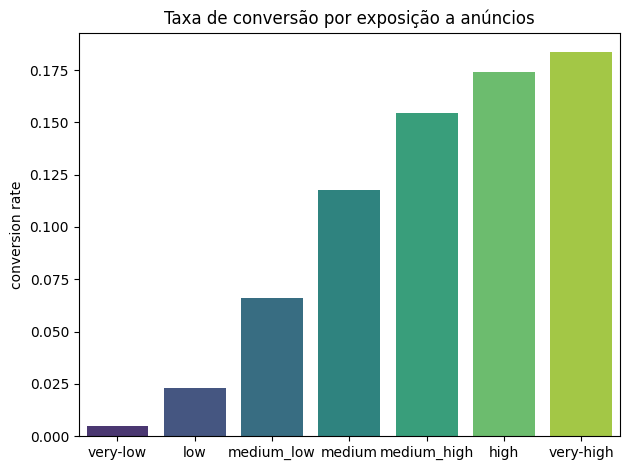

In [83]:
sns.barplot(ad_exposure_conversion_rate, palette='viridis')
plt.title('Taxa de conversão por exposição a anúncios')
plt.tight_layout()
plt.show()

In [84]:
percentage_better_arr = []
for i, index in enumerate(ad_exposure_conversion_rate.index):
  if i > 0:
    last_index = ad_exposure_conversion_rate.index[i-1]
    percentage_better = (ad_exposure_conversion_rate.loc[index] / ad_exposure_conversion_rate.loc[last_index]) - 1
    percentage_better *= 100
    percentage_better_arr.append(percentage_better)
    print(f'{index} possui {percentage_better:.2f}% mais conversões que {last_index}')

low possui 364.93% mais conversões que very-low
medium_low possui 185.73% mais conversões que low
medium possui 78.35% mais conversões que medium_low
medium_high possui 31.29% mais conversões que medium
high possui 12.76% mais conversões que medium_high
very-high possui 5.43% mais conversões que high


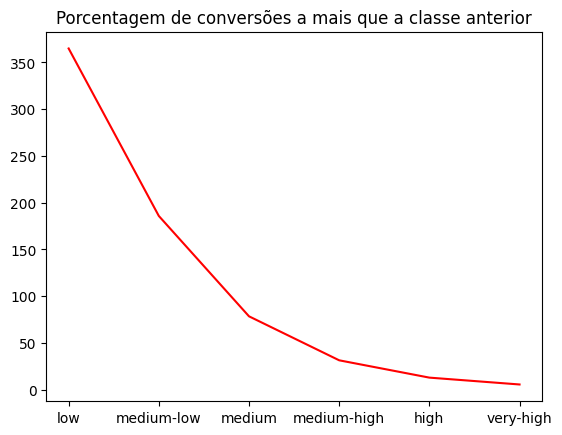

In [85]:
plt.plot(['low','medium-low', 'medium', 'medium-high', 'high', 'very-high'], percentage_better_arr, c='red')
plt.title('Porcentagem de conversões a mais que a classe anterior');

### Conclusões da Análise: "Anúncios Totais" e "Conversão"

Os usuários foram categorizados em sete faixas de exposição, baseadas no número total de anúncios vistos:


- **very-low**: entre 0 e 20 anúncios vistos
- **low**: entre 20 e 40 anúncios vistos
- **medium-low**: entre 40 e 60 anúncios vistos
- **medium**: entre 60 e 80 anúncios vistos
- **medium-high**: entre 80 e 100 anúncios vistos
- **high**: entre 100 e 120 anúncios vistos
- **very-high**: entre 120 e 140 anúncios vistos

#### Resultados

A taxa de conversão observada em cada faixa foi:

- **very-low**:	0.50%
- **low**:	2.31%
- **medium_low**:	6.60%
- **medium**:	11.77%
- **medium_high**:	15.45%
- **high**:	17.42%
- **very-high**:	18.36%

Comparação com a classe anterior:

- **low** possui 364.93% mais conversões que **very-low**
- **medium_low** possui 185.73% mais conversões que **low**
- **medium possui** 78.35% mais conversões que **medium_low**
- **medium_high** possui 31.29% mais conversões que **medium**
- **high** possui 12.76% mais conversões que **medium_high**
- **very-high** possui 5.43% mais conversões que **high**

Os dados sugerem que a exposição a anúncios tem um impacto positivo na conversão até certo ponto. No entanto, o crescimento percentual diminui à medida que a quantidade de anúncios aumenta, sugerindo um possível efeito de saturação. Isso indica que **exibir mais de 140 anúncios pode ser contraproducente**.

Estratégias de exposição devem focar em levar usuários até a faixa **medium-high (80-100 anúncios)**, pois depois disso o ganho marginal é pequeno.

### Teste A/B/n: "Dias com mais anúncios" e "Conversões"
Existe diferença significativa nas conversões dependendo do dia da semana que cada indivíduo mais viu anúncios?  
Se sim, quais dias foram mais importantes?

In [86]:
days_conversion = df.groupby(['most ads day', 'converted'])['converted'].count()
days_conversion

most ads day  converted
Friday        False        90551
              True          2057
Monday        False        84216
              True          2857
Saturday      False        79941
              True          1719
Sunday        False        83301
              True          2090
Thursday      False        81192
              True          1790
Tuesday       False        75167
              True          2312
Wednesday     False        78890
              True          2018
Name: converted, dtype: int64

In [87]:
converted_arr = days_conversion.iloc[1::2].values
not_converted_arr = days_conversion.iloc[0::2].values

days_conversion = pd.DataFrame({'converted': converted_arr,
                                  'not converted': not_converted_arr},
                                 index=['Friday', 'Monday', 'Saturday', 'Sunday',
                                        'Thursday', 'Tuesday', 'Wednesday'])

days_conversion['total'] = days_conversion['converted'] + days_conversion['not converted']

ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
days_conversion.index = pd.Categorical(days_conversion.index, categories=ordered_days, ordered=True)
days_conversion = days_conversion.sort_index()

days_conversion

,converted,not converted,total
Monday,2857,84216,87073
Tuesday,2312,75167,77479
Wednesday,2018,78890,80908
Thursday,1790,81192,82982
Friday,2057,90551,92608
Saturday,1719,79941,81660
Sunday,2090,83301,85391


In [88]:
print('Taxa de conversão por dia que mais viu anúncios')
days_conversion_rate = days_conversion['converted'] / days_conversion['total']
days_conversion_rate.name = 'conversion rate'
days_conversion_rate

Taxa de conversão por dia que mais viu anúncios


,conversion rate
Monday,0.032812
Tuesday,0.029840
Wednesday,0.024942
Thursday,0.021571
Friday,0.022212
Saturday,0.021051
Sunday,0.024476


In [89]:
contingency_table = days_conversion[['converted', 'not converted']].values

chi2, p, dof, expected = chi2_contingency(contingency_table)

In [90]:
print('Tabela de contingência:')
pd.DataFrame(contingency_table, columns=['converted', 'not converted'], index=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

Tabela de contingência:


,converted,not converted
Monday,2857,84216
Tuesday,2312,75167
Wednesday,2018,78890
Thursday,1790,81192
Friday,2057,90551
Saturday,1719,79941
Sunday,2090,83301


In [91]:
print("Valores esperados na tabela de contingência:")
pd.DataFrame(expected, columns=['converted (expected)', 'not converted (expected)'], index=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

Valores esperados na tabela de contingência:


,converted (expected),not converted (expected)
Monday,2197.623434,84875.376566
Tuesday,1955.481791,75523.518209
Wednesday,2042.025849,78865.974151
Thursday,2094.371249,80887.628751
Friday,2337.320535,90270.679465
Saturday,2061.005474,79598.994526
Sunday,2155.171668,83235.828332


In [92]:
print(f"Qui-quadrado: {chi2:.2f}")
print(f"p-valor: {p:.4f}")
print(f"Graus de liberdade: {dof}")

Qui-quadrado: 410.05
p-valor: 0.0000
Graus de liberdade: 6


In [93]:
for i, day_a in enumerate(days_conversion_rate.index):
  for j, day_b in enumerate(days_conversion_rate.index):
    if i != j and days_conversion_rate.iloc[i] > days_conversion_rate.iloc[j]:
      percentage_better = (days_conversion_rate.loc[day_a] / days_conversion_rate.loc[day_b]) - 1
      print(f'{day_a} converte {percentage_better*100:.2f}% a mais que {day_b}')

Monday converte 9.96% a mais que Tuesday
Monday converte 31.55% a mais que Wednesday
Monday converte 52.11% a mais que Thursday
Monday converte 47.72% a mais que Friday
Monday converte 55.87% a mais que Saturday
Monday converte 34.06% a mais que Sunday
Tuesday converte 19.64% a mais que Wednesday
Tuesday converte 38.34% a mais que Thursday
Tuesday converte 34.34% a mais que Friday
Tuesday converte 41.75% a mais que Saturday
Tuesday converte 21.92% a mais que Sunday
Wednesday converte 15.63% a mais que Thursday
Wednesday converte 12.29% a mais que Friday
Wednesday converte 18.48% a mais que Saturday
Wednesday converte 1.91% a mais que Sunday
Thursday converte 2.47% a mais que Saturday
Friday converte 2.97% a mais que Thursday
Friday converte 5.52% a mais que Saturday
Sunday converte 13.47% a mais que Thursday
Sunday converte 10.19% a mais que Friday
Sunday converte 16.27% a mais que Saturday


### Conclusões do Teste A/B/n: "Dias com mais anúncios" e "Conversões"

Para essa análise foi utilizado o **Teste Qui-Quadrado** com **Nível de Significância = 0.05**

Utilizando o Teste Qui-Quadrado, obtivemos um **p-valor < 0.0001**, indicando que há uma diferença estatística significativa entre os dias.

A taxa de conversão observada baseado no dia em que mais anúncios foram vistos foi:

- **Segunda**:	3.28%
- **Terça**:	2.98%
- **Quarta**:	2.49%
- **Quinta**:	2.16%
- **Sexta**:	2.22%
- **Sábado**:	2.11%
- **Domingo**:	2.45%

Comparações relevantes:

- **Segunda** possui 9.96% mais conversões que **Terça**
- **Segunda** possui 31.55% mais conversões que **Quarta**
- **Segunda** possui 52.11% mais conversões que **Quinta**
- **Segunda** possui 47.72% mais conversões que **Sexta**
- **Segunda** possui 55.87% mais conversões que **Sábado**
- **Segunda** possui 34.06% mais conversões que **Domingo**


- **Terça** possui 19.64% mais conversões que **Quarta**
- **Terça** possui 38.34% mais conversões que **Quinta**
- **Terça** possui 34.34% mais conversões que **Sexta**
- **Terça** possui 41.75% mais conversões que **Sábado**
- **Terça** possui 21.92% mais conversões que **Domingo**


- **Quarta** possui 15.63% mais conversões que **Quinta**
- **Quarta** possui 12.29% mais conversões que **Sexta**
- **Quarta** possui 18.48% mais conversões que **Sábado**
- **Quarta** possui 1.91% mais conversões que **Domingo**


- **Domingo** possui 13.47% mais conversões que **Quinta**
- **Domingo** possui 10.19% mais conversões que **Sexta**
- **Domingo** possui 16.27% mais conversões que **Sábado**

Os dados indicam que os dias iniciais da semana (segunda e terça) apresentam as taxas de conversão mais altas, seguidos por quarta e domingo. Portanto, para maximizar o retorno das campanhas publicitárias, recomenda-se concentrar esforços nesses dias, especialmente na segunda-feira, que obteve o desempenho superior.


### Teste A/B/n: "Horário com mais anúncios" e "Conversões"
Existe diferença significativa nas conversões dependendo horário que cada indivíduo mais viu anúncios?  
Se sim, quais horários foram mais importantes?

In [95]:
hours_conversion = df.groupby(['most ads hour', 'converted'])['converted'].count()

converted_arr = hours_conversion.iloc[1::2].values
not_converted_arr = hours_conversion.iloc[0::2].values

hours_conversion = pd.DataFrame({'converted': converted_arr,
                                  'not converted': not_converted_arr},
                                 index=np.arange(0,24))

hours_conversion['total'] = hours_conversion['converted'] + hours_conversion['not converted']

ordered_hours = np.arange(0,24)
hours_conversion.index = pd.Categorical(hours_conversion.index, categories=ordered_hours, ordered=True)
hours_conversion = hours_conversion.sort_index()

hours_conversion

,converted,not converted,total
0,102,5434,5536
1,62,4740,4802
2,39,5294,5333
3,28,2651,2679
4,11,711,722
5,16,749,765
6,46,2022,2068
7,116,6289,6405
8,344,17283,17627
9,595,30409,31004


In [96]:
print('Taxa de conversão por horário que mais viu anúncios')
hours_conversion_rate = hours_conversion['converted'] / hours_conversion['total']
hours_conversion_rate.name = 'conversion rate'
hours_conversion_rate

Taxa de conversão por horário que mais viu anúncios


,conversion rate
0,0.018425
1,0.012911
2,0.007313
3,0.010452
4,0.015235
5,0.020915
6,0.022244
7,0.018111
8,0.019516
9,0.019191


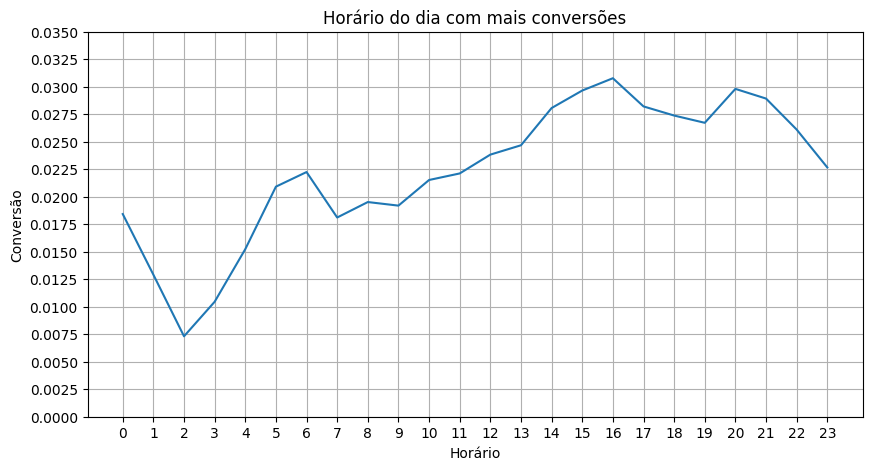

In [118]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0,24), hours_conversion_rate)
plt.title('Horário do dia com mais conversões')
plt.xticks(np.arange(0,24))
plt.yticks(np.arange(0, 0.035, 0.0025))
plt.xlabel('Horário')
plt.ylabel('Conversão')
plt.grid(True)
plt.show()

In [110]:
contingency_table = hours_conversion[['converted', 'not converted']].values

chi2, p, dof, expected = chi2_contingency(contingency_table)

In [111]:
print('Tabela de contingência:')
pd.DataFrame(contingency_table, columns=['converted', 'not converted'], index=np.arange(0,24))

Tabela de contingência:


,converted,not converted
0,102,5434
1,62,4740
2,39,5294
3,28,2651
4,11,711
5,16,749
6,46,2022
7,116,6289
8,344,17283
9,595,30409


In [112]:
print("Valores esperados na tabela de contingência:")
pd.DataFrame(expected, columns=['converted (expected)', 'not converted (expected)'], index=np.arange(0,24))

Valores esperados na tabela de contingência:


,converted (expected),not converted (expected)
0,139.722340,5396.277660
1,121.197015,4680.802985
2,134.598851,5198.401149
3,67.614911,2611.385089
4,18.222458,703.777542
5,19.307729,745.692271
6,52.193967,2015.806033
7,161.654911,6243.345089
8,444.885421,17182.114579
9,782.505678,30221.494322


In [113]:
print(f"Qui-quadrado: {chi2:.2f}")
print(f"p-valor: {p:.4f}")
print(f"Graus de liberdade: {dof}")

Qui-quadrado: 430.77
p-valor: 0.0000
Graus de liberdade: 23


### Conclusões do Teste A/B/n: "Horário com mais anúncios" e "Conversões"

Para essa análise foi utilizado o **Teste Qui-Quadrado** com **Nível de Significância = 0.05**

Utilizando o Teste Qui-Quadrado, obtivemos um **p-valor < 0.0001**, indicando que há uma diferença estatística significativa entre o horário.

A taxa de conversão observada baseado no horário em que mais anúncios pode ser visualizada no seguinte gráfico:



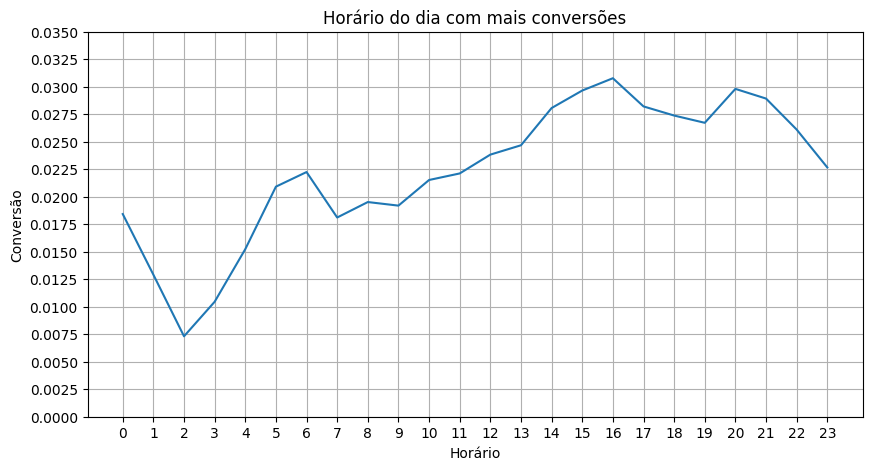

In [117]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0,24), hours_conversion_rate)
plt.title('Horário do dia com mais conversões')
plt.xticks(np.arange(0,24))
plt.yticks(np.arange(0, 0.035, 0.0025))
plt.xlabel('Horário')
plt.ylabel('Conversão')
plt.grid(True)
plt.show()

É possível notar um comportamento senoidal na taxa de conversão. Durante o período entre 00:00 e 09:00 horas, a conversão é significativamente menor. Por outro lado, a janela entre 14:00 e 21:00 horas revela-se mais propícia para conversões, sugerindo que a alocação de anúncios nesse período pode maximizar os resultados das campanhas.

O pior horário para conversão é 02:00hrs enquanto o melhor é 16:00hrs.

## Conclusões Gerais

### Grupos AD vs. PSA
A abordagem aplicada no grupo AD demonstrou um impacto positivo e relevante na taxa de conversão, com uma taxa de conversão entre 33.33% e 52.84% maior em relação ao grupo PSA.

### Quantidade de Anúncio
A exposição a anúncios tem efeito positivo na conversão, mas com ganhos marginais decrescentes após a faixa de 80-100 anúncios. Estratégias que ultrapassem essa faixa podem levar à saturação do usuário.

### Dias da Semana
Segunda e terça, são os mais promissores para conversões, justificando uma estratégia focada nesses períodos.

### Horários
A alocação de anúncios entre 14:00 e 21:00 horas é ideal, com o melhor desempenho às 16:00 hrs, enquanto horários muito cedo ou muito tarde apresentam desempenho inferior.